<a href="https://colab.research.google.com/github/cdbm/F1DataAnalysis/blob/master/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação 
o seguinte notebook foi feito para fazer predições usando modelos de classificação em cima do dataset da fórmula 1. Escolhemos o dataset de resultados, que contém os resultados de cada piloto em todas as corridas, para fazer nossa classificação. Para a classificação escolhemos a columa positions, que define em que posição o piloto terminou a corrida.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
results=pd.read_csv("https://raw.githubusercontent.com/cdbm/F1DataAnalysis/master/f1_data/results.csv")
races=pd.read_csv("https://raw.githubusercontent.com/cdbm/F1DataAnalysis/master/f1_data/races.csv")

Limpando o dataset para ter apenas pilotos que de fato terminaram as corridas.

In [3]:
results = results[results.position != '\\N']
results = results[results.milliseconds != '\\N']

O código a seguir foi feito para tornar mais possível a classificação. Como depois da limpeza restam poucas linhas (aproximadamente 6 mil) e o dataset não tem tantas features que podem ser usadas para o modelo e existem muitas classes possíveis para se predizer (19), resolvemos então transformar as 19 classes que seriam cada posição de chegada em classes mais abrangentes. O nosso modelo agora busca classificar entre as quatro classes de posições que um piloto pode chegar, entre os 5 primeiros, entre o 6º e o 10º, entre o 11º e o 15º e entre o 16º e 19º.

In [4]:
results.position = results.position.astype('int64')

In [5]:
results.loc[results['position'] <= 5, 'beans'] = 'TOP5'
results.loc[(results['position'] > 5) & (results['position'] <= 10) , 'beans'] = 'SIX_TO_TEN'
results.loc[(results['position'] > 10) & (results['position'] <= 15) , 'beans'] = 'EL_TO_FIFTEEN'
results.loc[(results['position'] > 15) & (results['position'] <= 20) , 'beans'] = 'SIXTEEN_TO_TWENTY'

Adicionando a informação de qual circuito foi o dado resultado


In [6]:
results["circuitId"] = results.raceId.map(races.set_index('raceId')['circuitId'])

In [7]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,beans,circuitId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,TOP5,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,TOP5,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,TOP5,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,TOP5,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,TOP5,1


Dropando features que ou não podem ser usadas, ou não são úteis ou são úteis até demais para o modelo.

In [8]:
results = results.drop('number', axis=1)
results = results.drop('statusId', axis=1)
results = results.drop('time', axis=1)
results = results.drop('fastestLapTime', axis=1)
results = results.drop('positionOrder', axis=1)
results = results.drop('positionText', axis=1)
results = results.drop('resultId', axis=1)
results = results.drop('fastestLapSpeed', axis=1)
results = results.drop('rank', axis=1)
results = results.drop('fastestLap',axis=1)

In [9]:
results = results.drop('position', axis=1)

Definição de tipos

In [10]:
results.milliseconds = results.milliseconds.astype('int64')
results.beans = results.beans.astype('category')

In [11]:
results.dtypes

raceId              int64
driverId            int64
constructorId       int64
grid                int64
points            float64
laps                int64
milliseconds        int64
beans            category
circuitId           int64
dtype: object

# Divisão do dataset em treinamento validação e teste

In [12]:
from sklearn.model_selection import train_test_split
features_results = results.drop('beans', axis=1)
labels_results = results['beans']

In [13]:
features_results

,raceId,driverId,constructorId,grid,points,laps,milliseconds,circuitId
0,18,1,1,1,10.0,58,5690616,1
1,18,2,2,5,8.0,58,5696094,1
2,18,3,3,7,6.0,58,5698779,1
3,18,4,4,11,5.0,58,5707797,1
4,18,5,1,3,4.0,58,5708630,1
...,...,...,...,...,...,...,...,...
24711,1035,20,6,11,0.0,52,4855363,9
24712,1035,832,1,12,0.0,52,4856063,9
24720,1036,1,131,1,25.0,66,5505279,4
24721,1036,830,9,3,18.0,66,5529456,4


In [14]:
labels_results

0                 TOP5
1                 TOP5
2                 TOP5
3                 TOP5
4                 TOP5
             ...      
24711    EL_TO_FIFTEEN
24712    EL_TO_FIFTEEN
24720             TOP5
24721             TOP5
24722             TOP5
Name: beans, Length: 6452, dtype: category
Categories (4, object): ['EL_TO_FIFTEEN', 'SIXTEEN_TO_TWENTY', 'SIX_TO_TEN', 'TOP5']

In [15]:
feature_train, feature_test, label_train, label_test = train_test_split(features_results, labels_results, test_size=0.2,random_state=1)
feature_train, feature_validation, label_train, label_validation =  train_test_split(feature_train, label_train, test_size=0.25,random_state=1)

In [16]:
print(feature_train.shape)
print(feature_test.shape)
print(feature_validation.shape)

(3870, 8)
(1291, 8)
(1291, 8)


Dicionário para guardar as métricas


In [17]:
stats = {}

# Criação, treinamento e avaliação dos modelos

Modelos escolhidos:


*   Naive bayes
*   KNN
*   MLP
*   





In [18]:
from sklearn.metrics import accuracy_score

Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB 
model_naive = GaussianNB()                       
model_naive.fit(feature_train, label_train)                  

prediction_test = model_naive.predict(feature_test)
prediction_train = model_naive.predict(feature_train)   

stats['naive_bayes_test'] = accuracy_score(label_test, prediction_test)
stats['naive_bayes_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['naive_bayes_test']))
print('precisão nos casos de treino: ' + str(stats['naive_bayes_train']))

precisão nos casos de teste: 0.6893880712625872
precisão nos casos de treino: 0.6545219638242894


KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=4)             
model_knn.fit(feature_train, label_train) 

prediction_test = model_knn.predict(feature_test)
prediction_train = model_knn.predict(feature_train)   

stats['knn_test'] = accuracy_score(label_test, prediction_test)
stats['knn_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['knn_test']))
print('precisão nos casos de treino: ' + str(stats['knn_train']))

precisão nos casos de teste: 0.5894655305964369
precisão nos casos de treino: 0.7423772609819121


MLP


In [21]:
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='sgd',random_state=1)
model_mlp.fit(feature_train, label_train) 

prediction_test = model_mlp.predict(feature_test)
prediction_train = model_mlp.predict(feature_train)   

stats['mlp_test'] = accuracy_score(label_test, prediction_test)
stats['mlp_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['mlp_test']))
print('precisão nos casos de treino: ' + str(stats['mlp_train']))

precisão nos casos de teste: 0.6901626646010844
precisão nos casos de treino: 0.6591731266149871


Random Forrest

In [22]:
from sklearn.ensemble import RandomForestClassifier
model_forrest = RandomForestClassifier(n_estimators=1000)
model_forrest.fit(feature_train, label_train) 

prediction_test = model_forrest.predict(feature_test)
prediction_train = model_forrest.predict(feature_train)   

stats['forrest_test'] = accuracy_score(label_test, prediction_test)
stats['forrest_train'] = accuracy_score(label_train, prediction_train)

print('precisão nos casos de teste: ' + str(stats['forrest_test']))
print('precisão nos casos de treino: ' + str(stats['forrest_train']))


precisão nos casos de teste: 0.9736638264910922
precisão nos casos de treino: 1.0


In [23]:
stats

{'forrest_test': 0.9736638264910922,
 'forrest_train': 1.0,
 'knn_test': 0.5894655305964369,
 'knn_train': 0.7423772609819121,
 'mlp_test': 0.6901626646010844,
 'mlp_train': 0.6591731266149871,
 'naive_bayes_test': 0.6893880712625872,
 'naive_bayes_train': 0.6545219638242894}

# MLFLOW


In [24]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = ""
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://fb3bf06ea449.ngrok.io


# Seleção de Hiper-parâmetros

In [25]:
!pip install optuna

Naive Bayes

In [ ]:
import optuna

def objective(trial):
    nb_var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e9, log=True)
    naive_obj = GaussianNB(var_smoothing=nb_var_smoothing)
    naive_obj.fit(feature_train, label_train)     

    prediction_test = naive_obj.predict(feature_test)
    prediction_train = naive_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

KNN


In [ ]:
def objective(trial):
    knn_n_neighbors = trial.suggest_int('n_neighbors', 2, 20)
    knn_weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    knn_algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])

    knn_obj = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, algorithm=knn_algorithm)
    knn_obj.fit(feature_train, label_train)     

    prediction_test = knn_obj.predict(feature_test)
    prediction_train = knn_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

MLP

In [ ]:
def objective(trial):
    mlp_max_iter = trial.suggest_int('max_iter', 50, 300)
    mlp_activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    mlp_solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])

    mlp_obj = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=mlp_max_iter,activation = mlp_activation,solver=mlp_solver,random_state=1)
    mlp_obj.fit(feature_train, label_train) 

    prediction_test = mlp_obj.predict(feature_test)
    prediction_train = mlp_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

Random Forrest


In [ ]:
def objective(trial):
    forrest_n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    forrest_criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    forrest_max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    forrest_obj = RandomForestClassifier(n_estimators=forrest_n_estimators, criterion=forrest_criterion, max_features=forrest_max_features)
    forrest_obj.fit(feature_train, label_train) 

    prediction_test = forrest_obj.predict(feature_test)
    prediction_train = forrest_obj.predict(feature_train)   

    accuracy_test = accuracy_score(label_test, prediction_test)
    accuracy_train = accuracy_score(label_train, prediction_train)
    return accuracy_test

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

In [32]:
forest_params = study.best_trial.params
print(study.best_trial)

FrozenTrial(number=93, value=0.9775367931835787, datetime_start=datetime.datetime(2020, 11, 14, 23, 16, 46, 518104), datetime_complete=datetime.datetime(2020, 11, 14, 23, 16, 50, 5189), params={'n_estimators': 428, 'criterion': 'entropy', 'max_features': 'log2'}, distributions={'n_estimators': IntUniformDistribution(high=1000, low=100, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=93, state=TrialState.COMPLETE)


# Diagnóstico do Modelo


In [36]:
from sklearn.metrics import confusion_matrix
forest_diag = RandomForestClassifier(n_estimators=forest_params['n_estimators'], criterion=forest_params['criterion'], max_features=forest_params['max_features'])
forest_diag.fit(feature_train, label_train) 

prediction_test = forest_diag.predict(feature_test)
prediction_train = forest_diag.predict(feature_train)   

accuracy_test = accuracy_score(label_test, prediction_test)
accuracy_train = accuracy_score(label_train, prediction_train)

mat = confusion_matrix(label_test, prediction_test)

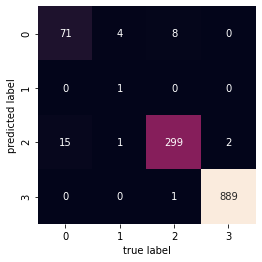

In [37]:
import seaborn as sns
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');